In [57]:
import getpass
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import oauthlib as oauth

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

import cv2
import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from typing import Optional

import torch
from torchvision import transforms
from torchmetrics.classification import JaccardIndex, MulticlassAccuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn.functional as F
from empatches import BatchPatching

from skimage import exposure
import numpy as np
import cv2
from skimage.morphology import disk, square
from skimage.filters import median

import os
from imutils import paths
from files import config

import torch
from torchvision import transforms
from torchmetrics.classification import JaccardIndex, MulticlassAccuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import os
from imutils import paths
from files import config
import DataCollection_Sentinel as DS

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    bbox_to_resolution,
    transform_point,
    get_utm_crs,
    aws,
    SentinelHubCatalog,
    Geometry,
)

#DataCollection
from __future__ import annotations
import math
from IPython.display import clear_output, display
import requests
import getpass
from sentinelhub import SHConfig
import datetime
import os
import matplotlib.pyplot as plt
from typing import Any
from pandas import to_datetime, date_range
import matplotlib.animation as animation
from PIL import Image
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from typing import Sequence, Tuple, List, Optional
import cv2
from empatches import BatchPatching
from torchvision import transforms
import torch
import files.config as Config
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.dates import DateLocator, DateFormatter
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance


from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    bbox_to_resolution,
    transform_point,
    get_utm_crs,
    aws,
    SentinelHubCatalog,
    Geometry,
)

file_path = os.getcwd()

access_token = DS.get_access_token(
"olivermillinge@live.dk",
getpass.getpass("Enter your password: "),
)


DS.setup_config(profile="OliverML",
              client="sh-f74155bc-d801-4214-b465-91dccbf00e36",
              secret="dOtgNKKlBsQYry8Gxt3u78WvgiqzvDsI")

Config = DS.Connect(profile="OliverML")


C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_3428\2623668338.py:98: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_3428\2623668338.py:99: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


Exception: Access token creation failed. Reponse from the server was: {'error': 'unknown_error'}

Total number of results: 3
['2023-09-28', '2023-09-28', '2023-09-28']
date 2023-09-28 is in True
['2023-09-28'] 


Image shape at (20, 40) m resolution: (1950, 1928) pixels


Resized image shape at (19.996978835319975, 40.003549094129355) m resolution: (905, 2480) pixels


Resized image shape at 
Partition size: (650, 1250) pixels, with resolution (19.996978835319975, 40.003549094129355) m and shape 3 x 2 partitions.

Original bbox coordinates: [-17.237549, 75.696646, -15.930176, 74.99641], Partioned BBox coordinates: (-16.735512746430754, 75.44006606896151, -16.272432473416053, 75.44302542123981)

[('2023-09-28T00:00:00Z', '2023-09-28T23:59:59Z')]
-16.735512746430754,75.44006606896151,-16.31196987642719,75.89105956655597


C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_12924\128846111.py:159: SHDeprecationWarning: The string representation of `BBox` will change to match its `repr` representation.
  print(BBoxPartition[1][1])


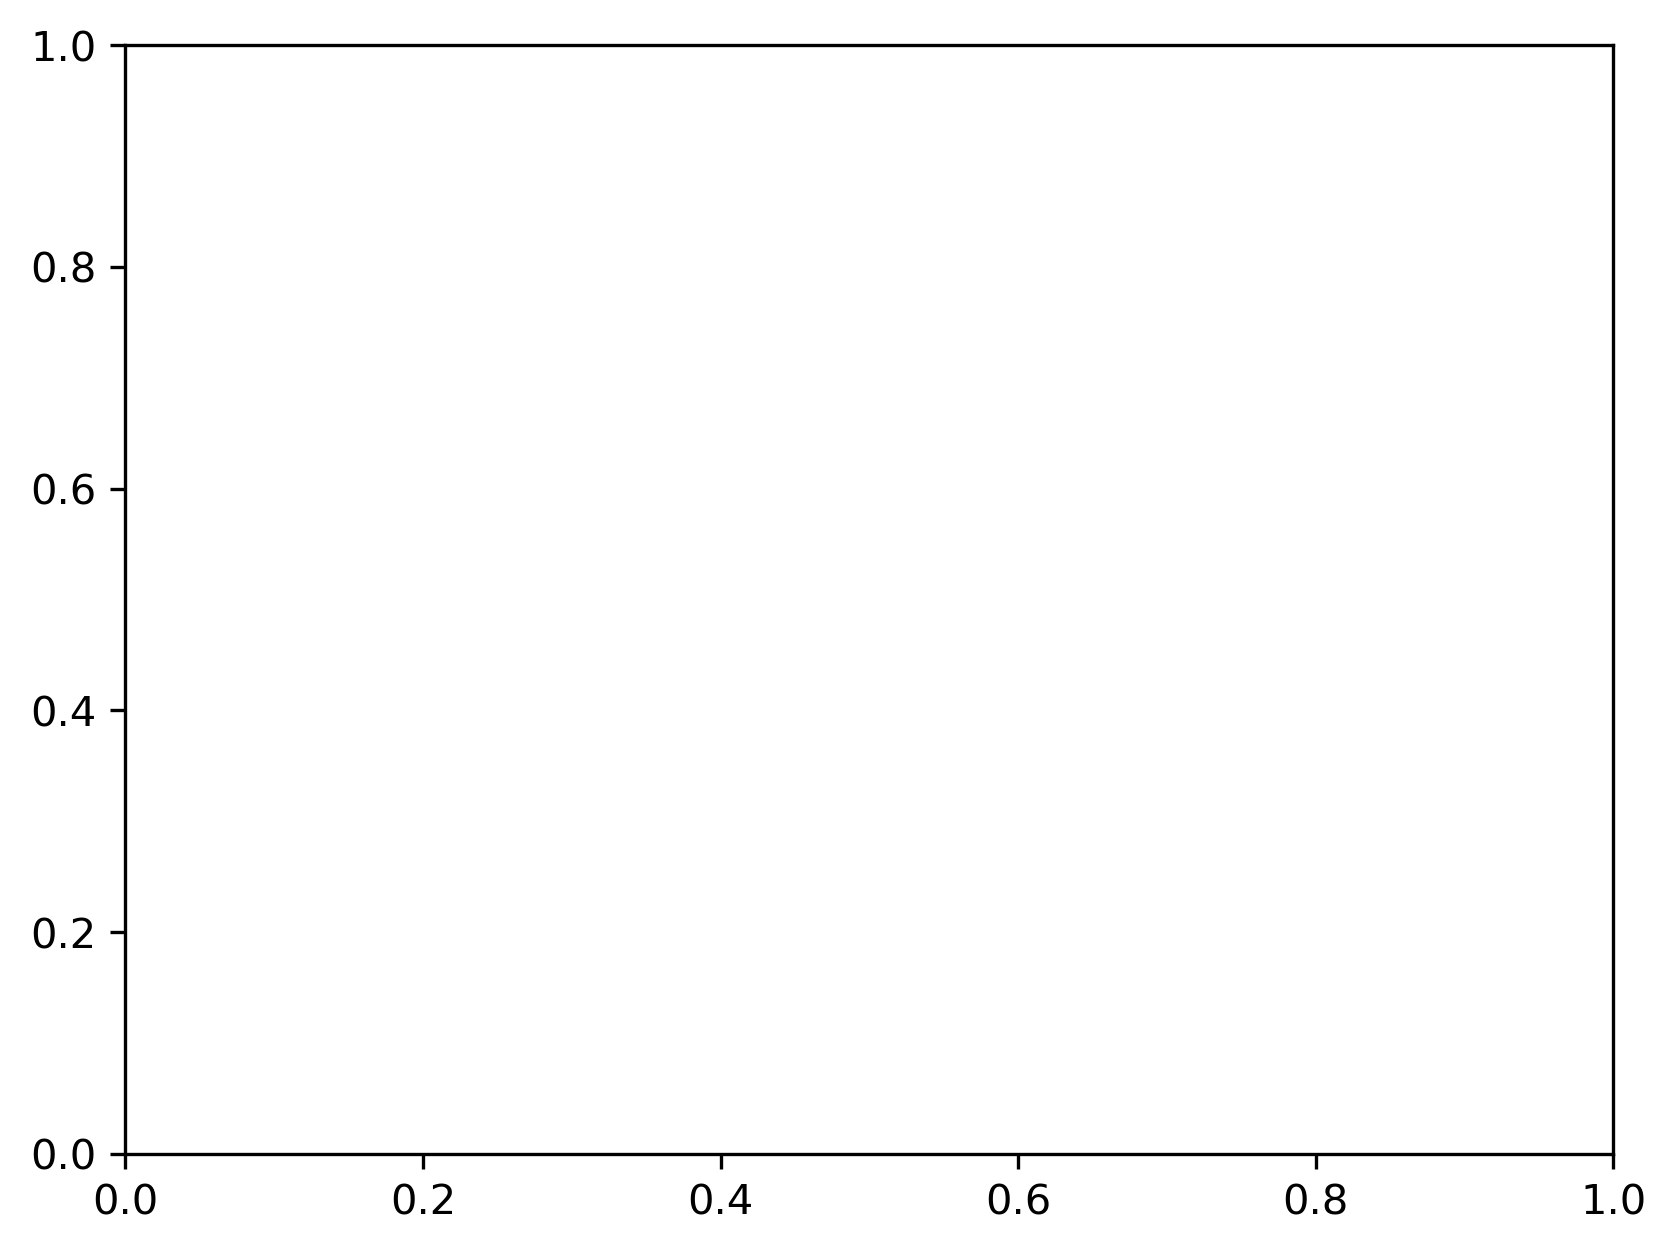

In [ ]:
evalscripts = {"evalscript1":  """
    //VERSION=3
    function setup() {
        return {
            input: ["HH", "dataMask"],
            output: { bands: 4 }
        }
    }

    function evaluatePixel(sample) {
        var value = 2 * sample.HH;
        value = Math.min(5, Math.max(-30, value));
        return [value, value, value, sample.dataMask];
    }
    """,

"evalscript2": """//VERSION=3
function setup() {
  return {
    input: ["HH", "dataMask"],
    output: [
      { id: "default", bands: 4 },
      { id: "eobrowserStats", bands: 1 },
      { id: "dataMask", bands: 1 },
    ],
  }
}

function evaluatePixel(samples) {
  const value = Math.max(0, Math.log(samples.HH) * 0.21714724095 + 1);
  return {
    default: [value, value, value, samples.dataMask],
    eobrowserStats: [(10 * Math.log(samples.HH)) / Math.LN10],
    dataMask: [samples.dataMask],
  };
}

// ---
/*
// displays HH in decibels from -20 to 0
// the following is simplified below
// var log = 10 * Math.log(HH) / Math.LN10;
// var val = Math.max(0, (log + 20) / 20);

return [Math.max(0, Math.log(HH) * 0.21714724095 + 1)];
*/"""}

#Functions for collecting the data
def collect_data(time_interval, AOI, Size, config, evalscript, datacollection):
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=datacollection,
                time_interval=time_interval,
            )
        ],
        processing={
            "orthorectify": "false",
            "backCoeff": "GAMMA0_ELLIPSOID",
            "speckleFilter": {
                "type": "LEE",
                "windowSizeX": 5,
                "windowSizeY": 5
            }
        },
        responses=[SentinelHubRequest.output_response("default", MimeType.JPG)],
        bbox=AOI,
        size=Size,
        config=config
    )

    image = request.get_data()

    return image

def raw_collect(time_interval, AOI, Size, config, evalscript, datacollection):
    request = {
    "input": {
        "bounds": {
            "bbox": BBCoords,
            "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/3857"},
        },
        "data": [
            {
                "type": "sentinel-1-grd",
                "dataFilter": {
                    "acquisitionMode": "EW",
                    "timeRange": {
                        "from": time_interval[0],
                        "to": time_interval[1],
                    },
                },
                "processing": {
                    "orthorectify": "false",
                    "backCoeff": "GAMMA0_ELLIPSOID",
                    "speckleFilter": {
                        "type": "LEE",
                        "windowSizeX": 5,
                        "windowSizeY": 5,
                    },
                },
            }
        ],
    },
    "output": {
        "width": Size[1],
        "height": Size[0],
        "responses": [
            {
                "identifier": "default",
                "format": {"type": "image/png"},
            }
        ],
    },
    "evalscript": evalscripts["evalscript2"],
}
    download_request = DownloadRequest(
        request_type="POST",
        url=Config.sh_token_url,
        post_values=request,
        data_type=MimeType.png,
        headers={"content-type": "application/json"},
        use_session=True,
    )

    client = SentinelHubDownloadClient(config=config)
    img = client.download(download_request)

    _, ax = plt.subplots(dpi=300, frameon=False)
    ax.imshow(frame[-1])
    ax.axis('off')

model = torch.load(os.path.join(file_path, "output/unet_oil.pth")).to(config.device)
BBCoords = [-17.237549,75.696646,-15.930176,74.99641]
ImWidth, ImHeight = 650, 1250                                       #Image width and height
resolution = (20,40)                                             #Resolution of the data
time_interval = "2023-09-28", "2023-09-28"                         #Time interval for the data
date = "2023-09-28"
raw_time = "2023-09-22T00:00:00Z", "2023-09-29T00:00:00Z"
datacollection = DataCollection.SENTINEL1_EW                          #Data collection to be used: s1, s1ew
mydpi = 96                                                         #DPI for plotting the images    

dates, res_up, total_possible_days, BBoxPartition, reBBoxSize = calculate_parameters(BBCoords, ImWidth, ImHeight, resolution, time_interval, datacollection, config=Config, filtered = True)
_, ax = plt.subplots(dpi=300, frameon=False)
local_time_interval = date, date
"""
frame = collect_data(local_time_interval, BBoxPartition[1][1],
                        reBBoxSize, Config, evalscripts["evalscript2"], datacollection)


ax.imshow(frame[-1])
ax.axis('off')
"""
raw_dates = []
for i in dates:
    raw_dates.append((i+"T00:00:00Z", i+"T23:59:59Z"))
print(raw_dates)
print(BBoxPartition[1][1])
CoordBBox = BBox(bbox=BBCoords, crs=CRS.WGS84)                     #Setup bbox, crs is a kind of coordinate reference system   
Size = bbox_to_dimensions(CoordBBox, resolution = resolution)



In [ ]:
#Function to sort out the data that isn't complete or overlapping dates of the loaded polygons
def extract_possible_dates(time_interval, coords, config, datacollection):
    catalog = SentinelHubCatalog(config=config)
    aoi_bbox = BBox(bbox=coords, crs=CRS.WGS84)
    search_iterator = catalog.search(
            datacollection,
            bbox=aoi_bbox,
            time=time_interval,
            fields={"include": ["geometry.coordinates", "properties.datetime"], "exclude": []},
        )

    results = list(search_iterator)
    print("Total number of results:", len(results))
    dates = [pd.to_datetime(result["properties"]["datetime"]).date().strftime("%Y-%m-%d") for result in results]
    print(dates)
    coordinates = [result['geometry']["coordinates"][0] for result in results ]
    collected_coords = []
    for d in dict.fromkeys(dates):
            collected_coords.append([coordinates[dates.index(d)+c] for c in range(dates.count(d))])
    multipolyray = []
    for i in range(len(collected_coords)):
        temp_poly_array = []
        for l in range(len(collected_coords[i][:])):
            multicoordray = []
            for s in collected_coords[i][l]:
                multicoordray.append((s[0],s[1]))
            temp_poly_array.append(Polygon(multicoordray))
        if len(temp_poly_array) != 1: 
            multipolyray.append(unary_union(temp_poly_array))
        else:
            multipolyray.append(temp_poly_array[0])

    location = Polygon(((coords[0],coords[1]),
                        (coords[2],coords[1]),
                        (coords[2],coords[3]),
                        (coords[0],coords[1]),
                        (coords[0],coords[1])))

    is_in = gpd.GeoSeries(multipolyray).contains(location)
    i = 0
    possible_dates = dict.fromkeys(dates)

    for d in possible_dates:
        print(f'date {d} is in {is_in[i]}')
        i +=1 
    
    dates = [date for date, is_in_value in zip(possible_dates, is_in) if is_in_value]
    print(dates, "\n")
    return dates

#Function to extract the dates with overlapping polygons
def extract_dates(time_interval, coords, config, datacollection):
    catalog = SentinelHubCatalog(config=config)
    aoi_bbox = BBox(bbox=coords, crs=CRS.WGS84)
    search_iterator = catalog.search(
            datacollection,
            bbox=aoi_bbox,
            time=time_interval,
            fields={"include": ["geometry.coordinates", "properties.datetime"], "exclude": []},
        )

    results = list(search_iterator)
    print("Total number of results:", len(results))
    dates = [pd.to_datetime(result["properties"]["datetime"]).date().strftime("%Y-%m-%d") for result in results]
    
    return dates

#Function to calculate the parameters for the data collection
def calculate_parameters(BBCoords, ImWidth, ImHeight, resolution, time_interval, datacollection, config, filtered):
    CoordBBox = BBox(bbox=BBCoords, crs=CRS.WGS84)                     #Setup bbox, crs is a kind of coordinate reference system          
    BBoxSize = bbox_to_dimensions(CoordBBox, resolution = resolution)  #Size of the bbox    
    if filtered == True:
        dates = list(reversed(dict.fromkeys(extract_possible_dates(
            time_interval, BBCoords, config, datacollection))))           #Finds the amount of dates available and fully complete
    else:
        dates = list(reversed(dict.fromkeys(extract_dates(
            time_interval, BBCoords, config, datacollection))))            #Finds the amount of dates available that arent fully complete
    
    total_possible_days = len(dates)                                    #Total amount of days available

    CoordsUtm1 = transform_point((BBCoords[0], BBCoords[1]),source_crs = CRS.WGS84,
                             target_crs = get_utm_crs(BBCoords[0], BBCoords[1]))
    CoordsUtm2 = transform_point((BBCoords[2], BBCoords[3]),source_crs = CRS.WGS84
                                ,target_crs = get_utm_crs(BBCoords[2], BBCoords[3]))

    UTMBBox = BBox(bbox=(CoordsUtm1[0], CoordsUtm1[1], CoordsUtm2[0], CoordsUtm2[1]), crs = get_utm_crs(BBCoords[0], BBCoords[1]))
    utm_BBoxSize = bbox_to_dimensions(UTMBBox, resolution = resolution)

    Distance_utmx, Distance_utmy = abs(CoordsUtm1[0] - CoordsUtm2[0]), abs(CoordsUtm1[1] - CoordsUtm2[1])

    partition_size_x = Distance_utmx * ((ImWidth/utm_BBoxSize[0]))   
    partition_size_y = Distance_utmy * ((ImHeight/utm_BBoxSize[1]))  #Lat / Long coordinates difference and resolution scale.

    BBoxPartition = UTMBBox.get_partition(size_x=partition_size_x,
                                            size_y=partition_size_y)  #Partition of the bbox for the data collection

    for i in range(len(BBoxPartition)):
        for j in range(len(BBoxPartition[0][:])):
            BBoxPartition[i][j] = BBox.transform(BBoxPartition[i][j], crs = CRS.WGS84)
    
    res_up = bbox_to_resolution(BBoxPartition[0][0], width=ImWidth, height=ImHeight)     #Resolution update to end up with 1250x650 image
    reBBoxSize = bbox_to_dimensions(BBoxPartition[0][0], resolution = res_up)              #Size of the bbox at the updated resolution

    ReBBCoords = (BBoxPartition[-1][0].lower_left[0],
            BBoxPartition[-1][0].lower_left[1],
            BBoxPartition[0][-1].upper_right[0],
            BBoxPartition[0][-1].upper_right[1])
    CoordReBBox = BBox(bbox=ReBBCoords, crs=CRS.WGS84)                     #Setup bbox, crs is a kind of coordinate reference system        
    ogReBBoxSize = bbox_to_dimensions(CoordReBBox, resolution = res_up)  #Size of the bbox at the updated resolution

    print(f"\nImage shape at {resolution} m resolution: {BBoxSize} pixels\n")
    print(f'\nResized image shape at {res_up} m resolution: {ogReBBoxSize} pixels\n')
    print(f"\nResized image shape at ")
    print(f'Partition size: {reBBoxSize} pixels, with resolution {res_up} m and shape {len(BBoxPartition)} x {len(BBoxPartition[0][:])} partitions.\n')
    #print(f'resolution error percentage: in x {round(abs(res_up[0]/resolution*100-100),2)}%, in y: {(round(abs(res_up[1]/resolution*100-100),2))} %\n')
    print(f'Original bbox coordinates: {BBCoords}, Partioned BBox coordinates: {BBoxPartition[0][0].upper_right[0],BBoxPartition[0][0].upper_right[1], BBoxPartition[-1][-1].lower_left[0],BBoxPartition[-1][-1].lower_left[1]}\n')
    return dates, res_up, total_possible_days, BBoxPartition, reBBoxSize

In [ ]:
"""//VERSION=3
function setup() {
  return {
    input: ["HH", "dataMask"],
    output: [
      { id: "default", bands: 4 },
      { id: "eobrowserStats", bands: 1 },
      { id: "dataMask", bands: 1 },
    ],
  }
}

function evaluatePixel(samples) {
  const value = Math.max(0, Math.log(samples.HH) * 0.21714724095 + 1);
  return {
    default: [value, value, value, samples.dataMask],
    eobrowserStats: [(10 * Math.log(samples.HH)) / Math.LN10],
    dataMask: [samples.dataMask],
  };
}

// ---
/*
// displays HH in decibels from -20 to 0
// the following is simplified below
// var log = 10 * Math.log(HH) / Math.LN10;
// var val = Math.max(0, (log + 20) / 20);

return [Math.max(0, Math.log(HH) * 0.21714724095 + 1)];
*/"""

"""//VERSION=3
function setup() {
  return {
    input: ["HH", "dataMask"],
    output: [
      { id: "default", bands: 4 },
      { id: "eobrowserStats", bands: 1 },
      { id: "dataMask", bands: 1 },
    ],
  }
}

// Speckle Filtering
function speckleFilter(image) {
    return image.focal_median({kernelType: 'circle', radius: 2, units: 'pixels'});
}

// Gamma Correction
function gammaCorrection(image, gamma) {
    return image.pow(gamma);
}

// Gain Correction
function gainCorrection(image, gain) {
    return image.multiply(gain);
}

function evaluatePixel(samples) {
  // Apply speckle filter to HH band
  const speckleFilteredHH = speckleFilter(samples.HH);

  // Apply gamma correction to speckle filtered HH band
  const gammaCorrectedHH = gammaCorrection(speckleFilteredHH, 1.5); // Adjust gamma value as needed

  // Apply gain correction to gamma corrected HH band
  const gainCorrectedHH = gainCorrection(gammaCorrectedHH, 1.2); // Adjust gain value as needed

  // Calculate value for visualization (similar to original script)
  const value = Math.max(0, Math.log(gainCorrectedHH) * 0.21714724095 + 1);

  return {
    default: [value, value, value, samples.dataMask],
    eobrowserStats: [(10 * Math.log(samples.HH)) / Math.LN10],
    dataMask: [samples.dataMask],
  };
}"""

Config

SHConfig(
  instance_id='********',
  sh_client_id='***********************************0e36',
  sh_client_secret='****************************vDsI',
  sh_base_url='https://sh.dataspace.copernicus.eu',
  sh_auth_base_url=None,
  sh_token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

In [ ]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = Config.sh_client_id
client_secret = Config.sh_client_secret

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
print(resp.content)

b'[]'


In [ ]:
import requests
from PIL import Image
import io

in_memory_file = io.BytesIO(response.content)
im = Image.open(in_memory_file)
im.show()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000024A5681F1D0>

In [ ]:
print(BBoxPartition[1][1])
print(BBoxPartition[1][1].lower_left)
print(BBoxPartition[1][1].upper_right)
bbcoords = (BBoxPartition[1][1].lower_left[0], BBoxPartition[1][1].lower_left[1], BBoxPartition[1][1].upper_right[0], BBoxPartition[1][1].upper_right[1])
print(str(file_path) + "/output/test"+str(number3)+str((number1,number2))+".png")
print(BBCoords)

-16.735512746430754,75.44006606896151,-16.31196987642719,75.89105956655597
(-16.735512746430754, 75.44006606896151)
(-16.31196987642719, 75.89105956655597)
c:\Users\Mr. Oliver\Desktop\CNN\FinalModels\UNet/output/test0(5, 1).png
[-17.237549, 75.696646, -15.930176, 74.99641]


C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_12924\233916318.py:1: SHDeprecationWarning: The string representation of `BBox` will change to match its `repr` representation.
  print(BBoxPartition[1][1])


C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_25768\987522037.py:5: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_25768\987522037.py:6: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


<Figure size 640x480 with 0 Axes>

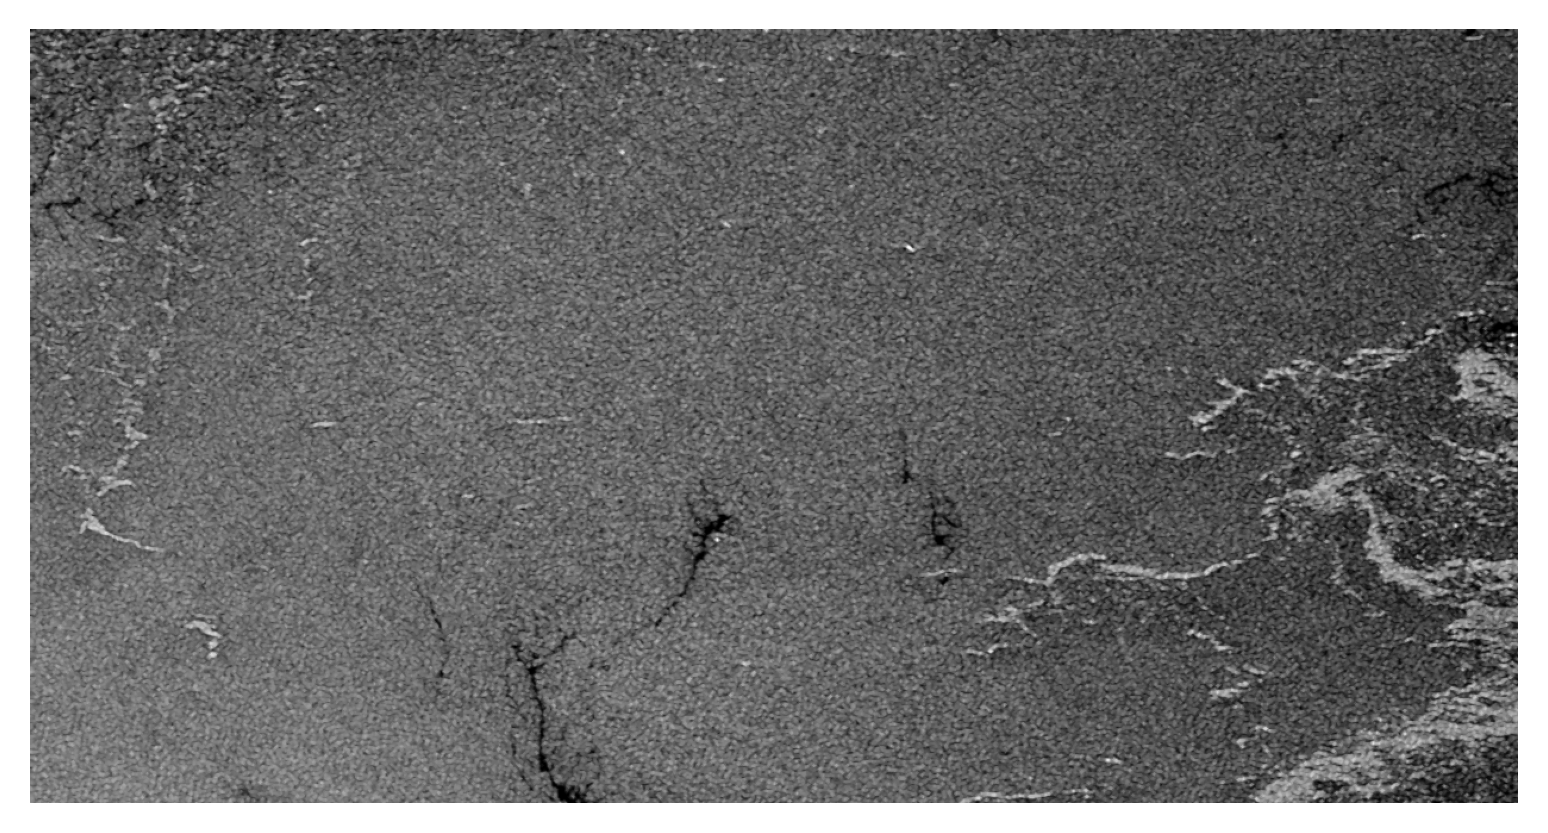

<Figure size 640x480 with 0 Axes>

In [ ]:
import cv2
from skimage.morphology import disk, square
from skimage.filters import median

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

import scipy
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.filters import unsharp_mask
from skimage.filters.rank import mean
from skimage.morphology import square
from skimage import img_as_ubyte

def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output



def lee_filter(image, window_size):
    """
    Lee filter for speckle noise reduction using scikit-image.
    
    Parameters:
    image (numpy.ndarray): Input image (2D array).
    window_size (int): Size of the square window for filtering.
    
    Returns:
    numpy.ndarray: Filtered image.
    """
    # Convert image to uint8 for skimage operations
    image = img_as_ubyte(image)
    
    # Apply mean filter (Lee filter approximation)
    filtered_image = mean(image, square(window_size))
    
    return filtered_image

# Example usage:
# Assuming 'image' is your input image and 'window_size' is the desired window size for filtering
# filtered_image = lee_filter(image, window_size=3)

img = cv2.imread("C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/UNet/image_4.png", cv2.IMREAD_GRAYSCALE)

img = unsharp_mask(img, radius=2, amount=1)

img = lee_filter(img, 2)
img = median(img, square(2))
_, ax = plt.subplots(dpi=300, frameon=False)
ax.axis('off')
ax.set_frame_on(False)
ax.imshow(img, cmap='gray')
ax.axis('off')
plt.imsave("C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/UNet/image_5_altered.png", img, cmap='gray')
plt.figure()

In [ ]:
number1 = 0
number2 = 0
number3 = 0
for i in raw_dates:
    #bordered_frames = []

    N = len(BBoxPartition)
    M = len(BBoxPartition[0][:])
    Size = bbox_to_dimensions(BBoxPartition[0][0], resolution = res_up)
    
    for n in range(N):
        for m in range(M):
            bbcoords = (BBoxPartition[n][m].lower_left[0], BBoxPartition[n][m].lower_left[1], BBoxPartition[n][m].upper_right[0], BBoxPartition[n][m].upper_right[1])
            request = {
                "input": {
                    "bounds": {
                        "bbox": bbcoords,
                        "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"},
                    },
                    "data": [
                        {
                            "type": "sentinel-1-grd",
                            "dataFilter": {
                                "acquisitionMode": "EW",
                                "timeRange": {
                                    "from": i[0],
                                    "to": i[1],
                                },
                            },
                            "processing": {
                                "orthorectify": "false",
                                "backCoeff": "GAMMA0_ELLIPSOID",
                                "speckleFilter": {
                                    "type": "LEE",
                                    "windowSizeX": 3,
                                    "windowSizeY": 3,
                                },
                            },
                        }
                    ],
                },
                "output": {
                    "width": Size[1],
                    "height": Size[0],
                    "responses": [
                        {
                            "identifier": "default",
                            "format": {"type": "image/png"},
                        }
                    ],
                },
                "evalscript": evalscripts["evalscript2"],
            }
            """download_request = DownloadRequest(
                request_type="POST",
                url="https://sh.dataspace.copernicus.eu/api/v1/process",
                post_values=request,
                data_type=MimeType.PNG,
                headers={"content-type": "application/json"},
                use_session=True,
            )"""

            print(i[0], i[1])
            """            client = SentinelHubDownloadClient(config=Config)
            img = client.download(download_request)"""


            url = "https://sh.dataspace.copernicus.eu/api/v1/process"
            response = oauth.post(url, json=request)

            in_memory_file = io.BytesIO(response.content)
            im = Image.open(in_memory_file)
            im.show()

            im.save(str(file_path) + "/output/test"+str(number3)+str((number1,number2))+".png")
            number1 += 1
        number2 += 1
    number3 += 1    

2023-09-28T00:00:00Z 2023-09-28T23:59:59Z
2023-09-28T00:00:00Z 2023-09-28T23:59:59Z
2023-09-28T00:00:00Z 2023-09-28T23:59:59Z


KeyboardInterrupt: 

In [ ]:

request = {
                "input": {
                    "bounds": {
                        "bbox": BBCoords,
                        "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"},
                    },
                    "data": [
                        {
                            "type": "sentinel-1-grd",
                            "dataFilter": {
                                "acquisitionMode": "EW",
                                "timeRange": {
                                    "from": i[0],
                                    "to": i[1],
                                },
                            },
                            "processing": {
                                "orthorectify": "false",
                                "backCoeff": "GAMMA0_ELLIPSOID",
                                "speckleFilter": {
                                    "type": "LEE",
                                    "windowSizeX": 3,
                                    "windowSizeY": 3,
                                },
                            },
                        }
                    ],
                },
                "output": {
                    "width": Size[1],
                    "height": Size[0],
                    "responses": [
                        {
                            "identifier": "default",
                            "format": {"type": "image/png"},
                        }
                    ],
                },
                "evalscript": evalscripts["evalscript2"],
            }
"""download_request = DownloadRequest(
    request_type="POST",
    url="https://sh.dataspace.copernicus.eu/api/v1/process",
    post_values=request,
    data_type=MimeType.PNG,
    headers={"content-type": "application/json"},
    use_session=True,
)"""

print(i[0], i[1])
"""            client = SentinelHubDownloadClient(config=Config)
img = client.download(download_request)"""


url = "https://sh.dataspace.copernicus.eu/api/v1/process"
response = oauth.post(url, json=request)

in_memory_file = io.BytesIO(response.content)
im = Image.open(in_memory_file)
im.show()

im.save(str(file_path) + "/output/testass.png")

NameError: name 'BBCoords' is not defined

[0 1]
[0 1 3]
[0 1 2 4]
[0 1 2]


C:\Users\Mr. Oliver\AppData\Local\Temp\ipykernel_10512\4064434757.py:49: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



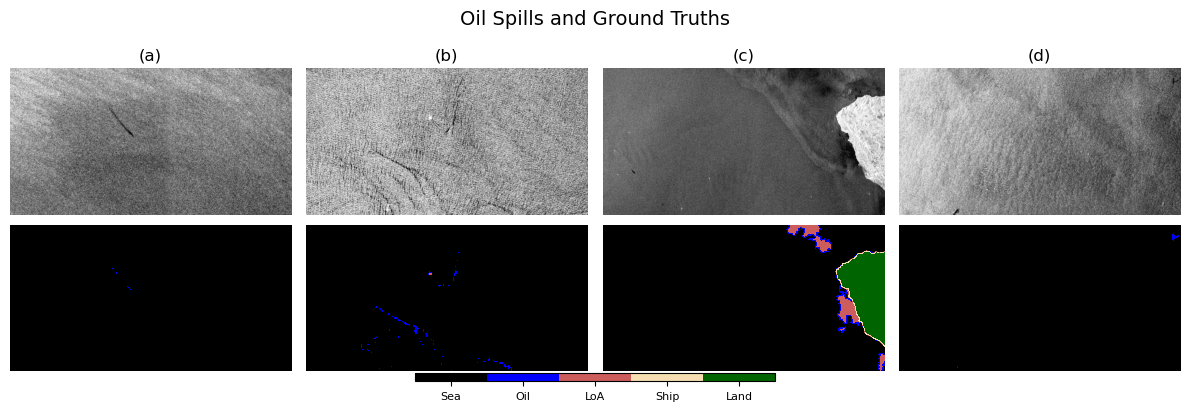

In [ ]:
imagePaths = ('c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0001.jpg','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0200.jpg','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0700.jpg','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0181.jpg','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0004.jpg','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0053.jpg','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0005.jpg','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\images\\img_0900.jpg')
GTpaths = ('c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\DeepLabV3\\dataset\\train\\labels_1D\\img_0001.png','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\DeepLabV3\\dataset\\train\\labels_1D\\img_0200.png','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\labels_1D\\img_0700.png','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\labels_1D\\img_0181.png','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\labels_1D\\img_0004.png','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\labels_1D\\img_0053.png','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\labels_1D\\img_0005.png','c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\dataset\\train\\labels_1D\\img_0900.png')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import numpy as np
import cv2
from PIL import Image
# Define file paths for images
oil_spills = imagePaths
ground_truths = GTpaths

# Define colormap and normalization
cmap = mcolors.ListedColormap(['black', 'blue', 'indianred', 'wheat', 'darkgreen'])
Norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5], cmap.N)
norm = Normalize(vmin=0, vmax=5)
list_a = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
# Create a figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 4))

# Set title
fig.suptitle('Oil Spills and Ground Truths', fontsize=14)

# Loop through images and plot
for i in range(4):
    # Plot oil spills
    img_oil = cv2.imread(oil_spills[i])
    axs[0, i].imshow(img_oil)
    axs[0, i].axis('off')
    axs[0, i].set_title(list_a[i])
    
    # Plot ground truths
    img_truth = cv2.imread(ground_truths[i], cv2.IMREAD_GRAYSCALE)
    print(np.unique(img_truth))
    axs[1, i].imshow(img_truth, cmap=cmap, norm=Norm)
    axs[1, i].axis('off')
    
    axs[1, i].axis('off')
    #axs[1, i].set_title('Ground Truth {}'.format(i+1))
    
    # Plot predicted mask (assuming you have a variable predMask containing your predicted masks)
    cb = axs[1, i].imshow(img_truth, cmap=cmap, norm=Norm)
    if i == 0:  # Only plot colorbar once
        cbar_ax = fig.add_axes([0.35, 0.05, 0.3, 0.02])  # Position of colorbar at bottom middle
        cbar = fig.colorbar(cb, cax=cbar_ax, orientation='horizontal', ticks=[0+0.5, 1+0.5, 2+0.5, 3+0.5, 4+0.5])
        cbar.ax.set_xticklabels(['Sea', 'Oil', 'LoA', 'Ship', 'Land'], fontsize=8)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for i in imagePaths:
    # Open the image with PIL
    image_pil = Image.open(i)

    # Display the image
    image_pil.show()



NameError: name 'imagePaths' is not defined

Image mean: 4.4685267692307695 Image std: 10.578052760549825
exp:  1.457633932868763
1.457633932868763
Image mean: 66.1590363076923 Image std: 56.955850289694276
exp:  1.0849934793753682
1.0849934793753682
Image mean: 0.2861046153846154 Image std: 5.2194978975857245
exp:  1.927460070276652
1.927460070276652
Image mean: 176.9513316923077 Image std: 17.63999206380806
exp:  1.2744261941498096
1.2744261941498096


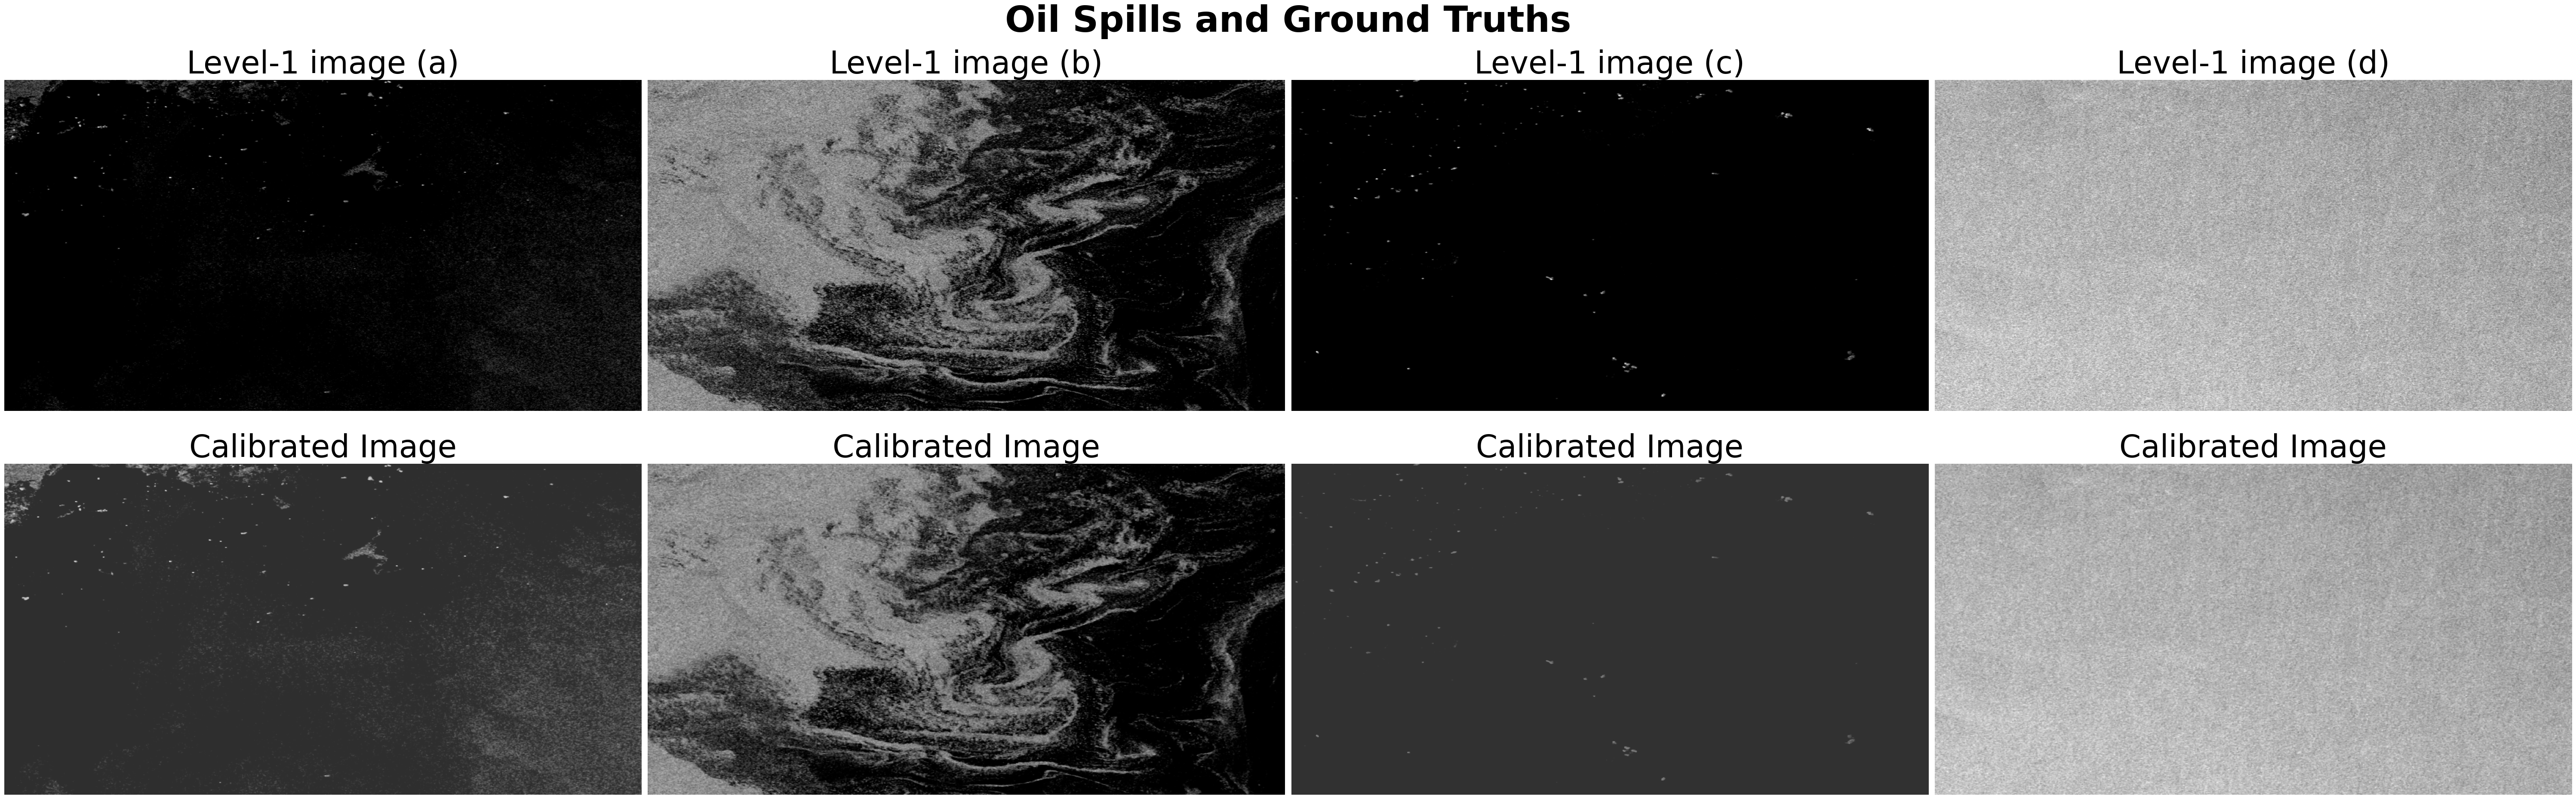

In [ ]:
imagePaths = ('c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\output\\TestVsTraingPlot\\Train')
TestPaths = ('c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\output\\TestVsTraingPlot\\Test')

import numpy as np
import cv2
from skimage import exposure
import numpy as np
import cv2
from skimage.morphology import disk, square
from skimage.filters import median

from sklearn import preprocessing
import pandas as pd


def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def post_process2(img):
    mean = np.mean(img)
    std = np.std(img)
    
    min_std, max_std = 18.2, 84.70
    min_mean, max_mean = 49.20, 229.66
    training_std = 48.40875886903693
    training_mean = 132.16870970854248
    gain_factor = 1.1135738581847063 
    exp_factor = 1.105646659783418
    
    # Convert input image to float32
    img = img.astype(np.float32)

    # Apply gain and exposure adjustment
    img = cv2.multiply(img, gain_factor)
    #img = cv2.pow(img, exp_factor)  # Apply gamma correction
    
    # Adjust mean and std
    if std < min_std:
        scale_std = std / min_std
    elif std > max_std:
        scale_std = max_std / std
    else:
        scale_std = 1.0
        
    if mean < min_mean:
        wanted_mean = min_mean
    elif mean > max_mean:
        wanted_mean = max_mean
    else:
        wanted_mean = mean
        
    img = scale_std * (img - mean) + wanted_mean
    
    # Apply median filter
    for i in range(3):
        img[:,:,i] = median(img[:,:,i], disk(1))
    
    return img.astype(np.uint8)

def post_process(img):
    mean = np.mean(img)
    std = np.std(img)
    
    print("Image mean:", mean, "Image std:", std)
    
    min_std, max_std = 18.2, 84.70
    min_mean, max_mean = 49.20, 229.66
    training_std = 48.40875886903693
    
    training_mean = 132.16870970854248
    gain_factor = 1.1135738581847063 
    exp_factor = 0.1
    #gain = (mean / min_mean)*gain_factor+1
    exp = (training_std / std)*exp_factor+1
    print("exp: ", exp)

    #img = cv2.multiply(img, gain)
    #img = exposure.adjust_log(img, exp)

    if std < min_std:
        scale_std = std / min_std
    elif std > max_std:
        scale_std = max_std / std
    else:
        scale_std = 1.0
    if mean < min_mean:
        wanted_mean = min_mean
        img = cv2.multiply(img, 1+gain_factor)
    elif mean > max_mean:
        wanted_mean = max_mean
    else:
        wanted_mean = mean

    # Adjust mean and std
    img = scale_std * (img - mean) + wanted_mean
    print(exp)
    for i in range(3):
        #img[:,:,i] = lee_filter(img[:,:,i], 1)
        img[:,:,i] = median(img[:,:,i], disk(1))
    
    #img = exposure.adjust_log(img, exp)
    return img.astype(np.uint8)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import numpy as np
import cv2
from PIL import Image
# Define file paths for images
TrainiMPaths = np.array(sorted(list(paths.list_images(imagePaths))))
TestPaths = np.array(sorted(list(paths.list_images(TestPaths))))

list_a = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Create a figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(60, 20))

# Set title
fig.suptitle('Oil Spills and Ground Truths', fontsize=60, fontweight='bold')

# Loop through images and plot
for i in range(4):
    # Plot oil spills
    img_truth = cv2.imread(TestPaths[i])
    calibrated_im = post_process(img_truth)
    axs[0, i].imshow(img_truth)
    axs[0, i].axis('off')
    axs[0, i].set_title('Level-1 image '+ list_a[i], fontsize=52,  )
    
    # Plot ground truths
    axs[1, i].imshow(calibrated_im)
    axs[1, i].axis('off')
    axs[1, i].set_title('Calibrated Image', fontsize=52)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
model = torch.load("C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/unet/output/10/unet_oil.pth").to(config.device)
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 196.920MB


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

4379541

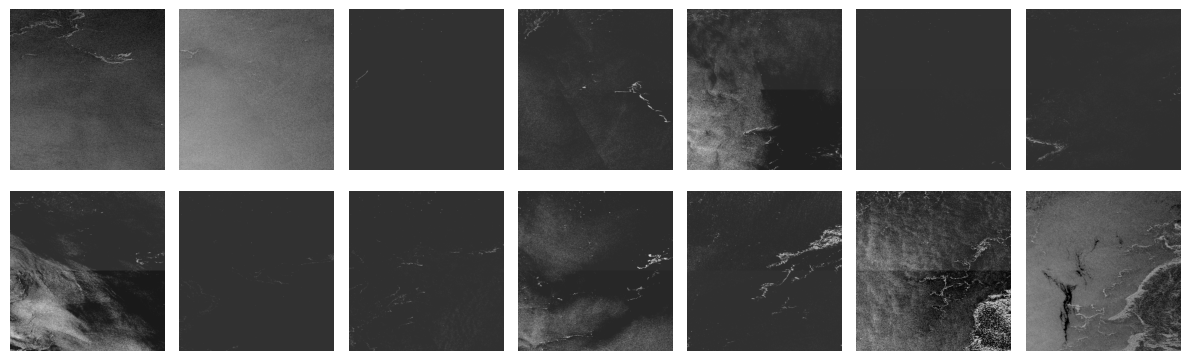

In [65]:
import numpy as np
import cv2
from skimage import exposure
import numpy as np
import cv2
from skimage.morphology import disk, square
from skimage.filters import median

from sklearn import preprocessing
import pandas as pd


def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output


def post_process(img):
    mean = np.mean(img)
    std = np.std(img)
    
    #print("Image mean:", mean, "Image std:", std)
    
    min_std, max_std = 18.2, 84.70
    min_mean, max_mean = 49.20, 229.66
    training_std = 48.40875886903693
    
    training_mean = 132.16870970854248
    gain_factor = 1.1135738581847063 
    exp_factor = 0.1
    #gain = (mean / min_mean)*gain_factor+1
    exp = (training_std / std)*exp_factor+1
    #print("exp: ", exp)

    #img = cv2.multiply(img, gain)
    #img = exposure.adjust_log(img, exp)

    if std < min_std:
        scale_std = std / min_std
    elif std > max_std:
        scale_std = max_std / std
    else:
        scale_std = 1.0
    if mean < min_mean:
        wanted_mean = min_mean
        img = cv2.multiply(img, 1+gain_factor)
    elif mean > max_mean:
        wanted_mean = max_mean
    else:
        wanted_mean = mean

    # Adjust mean and std
    img = scale_std * (img - mean) + wanted_mean
    #print(exp)
    for i in range(3):
        #img[:,:,i] = lee_filter(img[:,:,i], 1)
        img[:,:,i] = median(img[:,:,i], disk(1))
    
    #img = exposure.adjust_log(img, exp)
    return img.astype(np.uint8)

def merge_patches(patches, N, M):

    # Reshape the list of frames into a 2D grid
    #print(np.array(patches[::-1]).shape, len(patches))
    grid_frames = np.array(patches[::-1]).reshape((N, M, *patches[0].shape))
    #print(grid_frames.shape)

    # Concatenate along the rows to merge frames within each row
    merged_columns = [np.concatenate(column, axis=0) for column in grid_frames]
    #print(merged_columns[0].shape)

    # Concatenate the rows vertically to form the final merged image
    merged_image = np.concatenate(merged_columns[::-1], axis=1)
    return merged_image

def TemporalPredict(IMFolder, model, Highlights: Optional[list]=None):

    # Get images at path
    imagePath = np.array(sorted(list(paths.list_images(IMFolder))))

    #Get amount of images to merge
    temp = []
    for path in imagePath:
        temp.append(int(str(imagePath).split("_")[-1].split(".")[0]))
    
    num_merge = np.max(temp)

    #Get dates
    dates = []
    for path in imagePath:
        dates.append(path[len(IMFolder)+1:len(imagePath[0])-len(str(num_merge))-5])
    dates = list(np.unique(dates))

    #Grouping images. Currently assumes all images are stacked and not tiled.
    image_groups = []
    if num_merge > 1:
        for i in range(int(len(imagePath)/num_merge)):
            temp = []
            for j in range(num_merge):
                temp.append(cv2.imread(imagePath[i*num_merge+j]))
            image_groups.append(temp)
    else:
        for i in range(len(imagePath)):
            image_groups.append([cv2.imread(imagePath[i])])
    
    merged_predictions = []
    merged_orig = []

    #Loop through all image groups
    for i, imagegroup in enumerate(image_groups):
        merging_group = []
        merged_orig_group = []
        for image in imagegroup:

            #Apply extra preprocessing
            image = post_process(image)

            # Disable gradient calculation
            with torch.no_grad():
                
                # Set model to evaluation mode
                model.eval()

                # Convert image to PyTorch tensor
                image = transforms.ToTensor()(image).type(torch.float)
                x = torch.unsqueeze(image, dim=0)

                # Calculate the amount of padding needed
                target_height = ((x.size(2) + 31) // 32) * 32
                target_width = ((x.size(3) + 31) // 32) * 32
                padding_height = target_height - x.size(2)
                padding_width = target_width - x.size(3)

                # Apply zero-padding
                padded_image = F.pad(x, (0, padding_width, 0, padding_height))
                resized_image = transforms.Resize((target_height, target_width))(x)

                orig = image.cpu().detach().numpy().transpose(1, 2, 0).copy()

                # Get predictions from the model
                predMask = model(padded_image.to(config.device))
                predMask = predMask[:, :, :650, :1250]
                predMask = model(resized_image.to(config.device))
                predMask = transforms.Resize((650, 1250), interpolation=transforms.InterpolationMode.BILINEAR)(predMask)

                # Use argmax to get the index of the class with the highest probability
                predicted_classes = torch.argmax(predMask, dim=1)

                # Create a binary mask based on the predicted class
                mask = torch.zeros_like(predMask)
                mask.scatter_(1, predicted_classes.unsqueeze(1), 1)

                # Assign values based on the predicted class
                background_value = 0
                oil_spill_value = 1
                look_alike_value = 0
                ships_value = 0
                land_value = 0

                # Assign values based on the predicted class
                result_image = (
                    mask[:, 0:1, :, :] * background_value +
                    mask[:, 1:2, :, :] * oil_spill_value +
                    mask[:, 2:3, :, :] * look_alike_value +
                    mask[:, 3:4, :, :] * ships_value +
                    mask[:, 4:5, :, :] * land_value
                )
                
                #Resulting image
                result_image = result_image.cpu().numpy()
                result_image = result_image.astype(np.uint8).squeeze()

                #Group of images that need to be merged
            merging_group.append(result_image)
            merged_orig_group.append(orig)
        merged_orig.append(merged_orig_group)
        merged_predictions.append(merging_group)
    final_predictions = []
    final_origs = []

    if num_merge != 1:
        for merging_group in merged_predictions:
            final_predictions.append(merge_patches(merging_group[:], 1, len(merging_group)))
        for merging_group in merged_orig:
            final_origs.append(merge_patches(merging_group[:], 1, len(merging_group)))
    else:
        for merging_group in merged_predictions:
            final_predictions.append(merging_group[0])
        for merging_group in merged_orig:
            final_predictions.append(merged_orig_group[0])
    return final_predictions, final_origs, dates
    


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import numpy as np
import cv2
from PIL import Image

imagePaths = ('c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\output\\TemporalDays\\current')
#TestPaths = ('c:\\Users\\Mr. Oliver\\Desktop\\CNN\\FinalModels\\UNet\\output\\TestVsTraingPlot\\Test')
model = torch.load('c:/Users/Mr. Oliver/Desktop/CNN/FinalModels/DeepLabV3/output/28/unet_oil.pth').to(config.device)
# Define file paths for images
TestPaths = np.array(sorted(list(paths.list_images(imagePaths))))
#TestPaths = np.array(sorted(list(paths.list_images(TestPaths))))
final_predictions, final_origs, dates = TemporalPredict(imagePaths, model)

list_a = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Create a figure and subplots
"""fig, axs = plt.subplots(len(final_predictions) , 2, figsize=(20, 20))

cmap = mcolors.ListedColormap(['black', 'blue', 'indianred', 'wheat', 'darkgreen'])
norm = Normalize(vmin=0.0, vmax=4.0)
# Loop through images and plot
for i in range(len(final_predictions)):
    # Plot oil spills
    img_truth = final_predictions[i]
    calibrated_im = final_origs[i]
    axs[0].imshow(img_truth, cmap=cmap, norm=norm)
    axs[0].axis('off')
    
    # Plot ground truths
    axs[1].imshow(calibrated_im, cmap=cmap, norm=norm)
    axs[1].axis('off')


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()"""

fig, axs = plt.subplots(2 ,int(len(final_predictions)/2), figsize=(12, 4))

#cmap = mcolors.ListedColormap(['black', 'blue', 'indianred', 'wheat', 'darkgreen'])
#norm = Normalize(vmin=0.0, vmax=4.0)
# Loop through images and plot
e = 0
for j in range(2):
    for i in range(int(len(final_predictions)/2)):
        # Plot oil spills
        #img_truth = final_predictions[e]
        calibrated_im = final_origs[e]
        axs[j, i].imshow(calibrated_im, cmap=cmap, norm=norm)
        axs[j, i].axis('off')
        
        """        # Plot ground truths
        axs[1].imshow(calibrated_im, cmap=cmap, norm=norm)
        axs[1].axis('off')"""
        e = e+1

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()